## Install dependencies

In [28]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna

In [29]:
import matplotlib.pyplot as plt

## Variables

## Formulas

In [30]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

## Get data

In [31]:
df = pd.read_csv('/Users/anhhung/Desktop/DSP_vn30f/dataf.csv')

Fill missing data

In [32]:
from pandas import Series,DataFrame
# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [33]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0


In [34]:
sub_df = df.copy()
sub_df.set_index('Date', inplace=True)

In [35]:
sub_df[sub_df.index > '2023-04']

,Open,High,Low,Close,Volume
Date,,,,,
2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,3444.0
2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,3444.0
2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,3444.0
2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,1419.0
2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,1419.0
...,...,...,...,...,...
2024-06-21 14:27:00,1319.9,1319.9,1318.4,1319.3,2757.0
2024-06-21 14:28:00,1319.3,1319.3,1317.6,1318.0,2003.0
2024-06-21 14:29:00,1317.8,1318.0,1317.5,1317.5,1889.0


In [36]:
sub_df.index = pd.to_datetime(sub_df.index)

# Descriptive statistic

In [37]:
sub_df.describe()

,Open,High,Low,Close,Volume
count,352616.000000,352616.000000,352616.000000,352616.000000,352616.000000
mean,1094.962558,1095.318602,1094.608515,1094.963409,828.033368
std,234.245974,234.323792,234.166895,234.244661,1066.171245
min,563.000000,566.000000,560.100000,565.000000,1.000000
25%,888.800000,889.000000,888.600000,888.800000,286.000000
50%,1064.500000,1064.900000,1064.000000,1064.500000,545.000000
75%,1265.000000,1265.500000,1264.500000,1265.000000,1007.000000
max,1576.600000,1576.900000,1575.800000,1576.700000,158907.000000


# Plotting

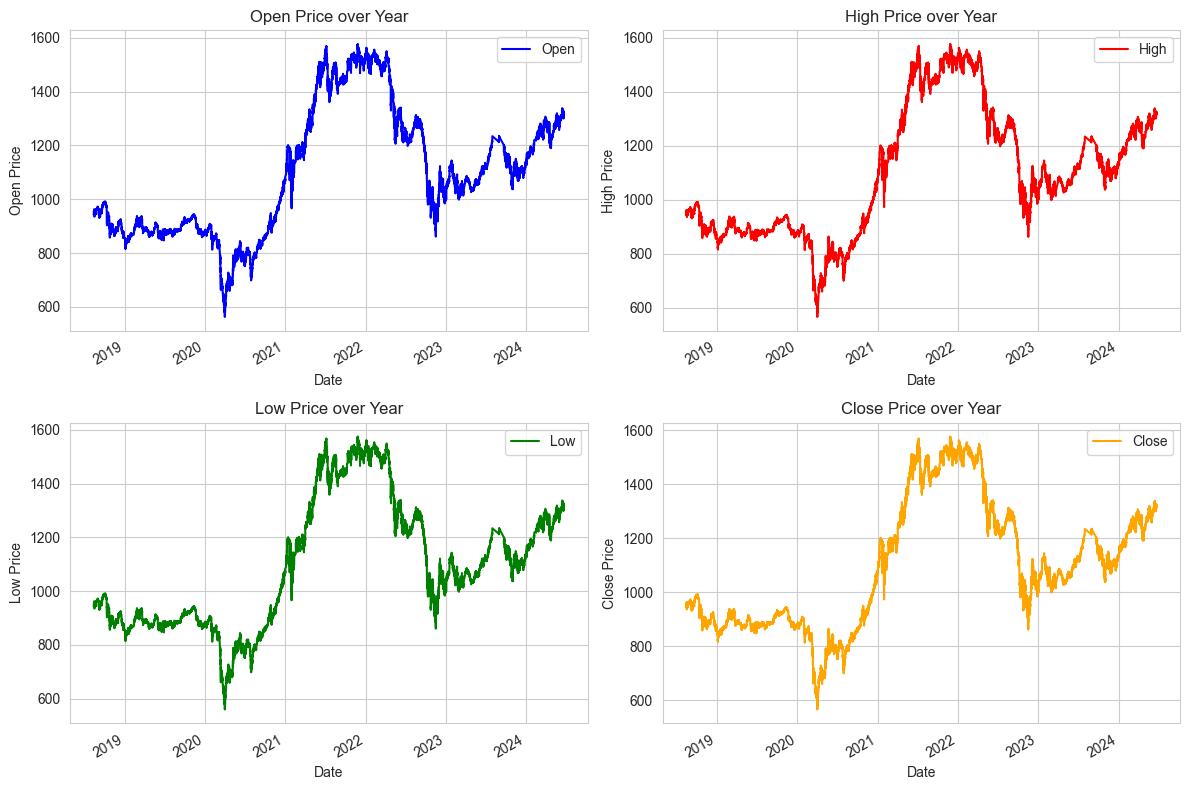

In [38]:
import matplotlib.pyplot as plt

columns = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'red', 'green', 'orange']

# Tạo các subplots với layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Chuyển đổi axs thành một mảng 1 chiều để dễ truy cập
axs = axs.flatten()

for i, column in enumerate(columns):
    sub_df[column].plot(ax=axs[i], legend=True, color=colors[i])
    axs[i].set_title(f'{column} Price over Year')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(f'{column} Price')

plt.tight_layout()  # Điều chỉnh layout cho đẹp
plt.show()


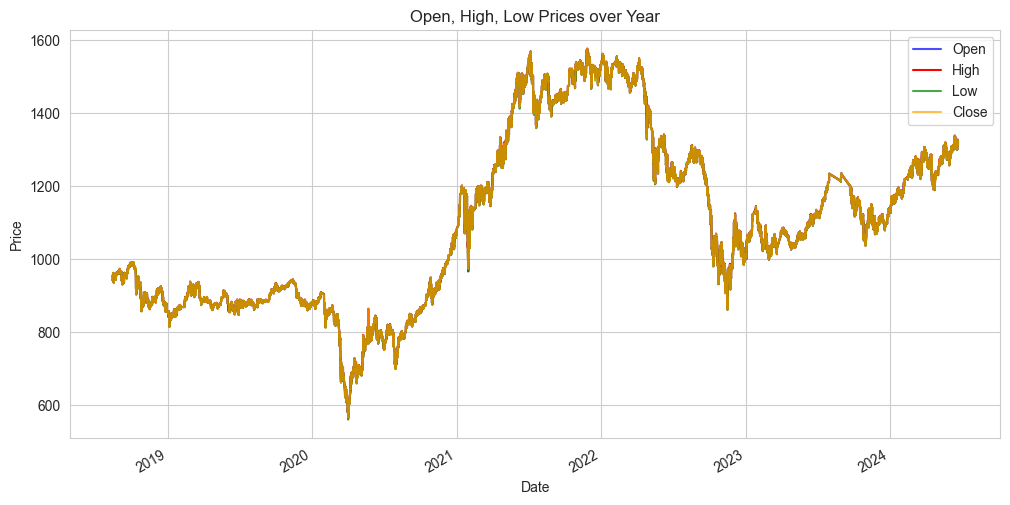

In [39]:
import matplotlib.pyplot as plt

columns = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'red', 'green', 'orange']

# Tạo plot chính
fig, ax = plt.subplots(figsize=(12, 6))

for i, column in enumerate(columns):
   if column == 'High':
      sub_df[column].plot(ax=ax, color=colors[i], label=column, alpha=1)
   else:
      sub_df[column].plot(ax=ax, color=colors[i], label=column, alpha=0.7)

ax.set_title('Open, High, Low Prices over Year')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()


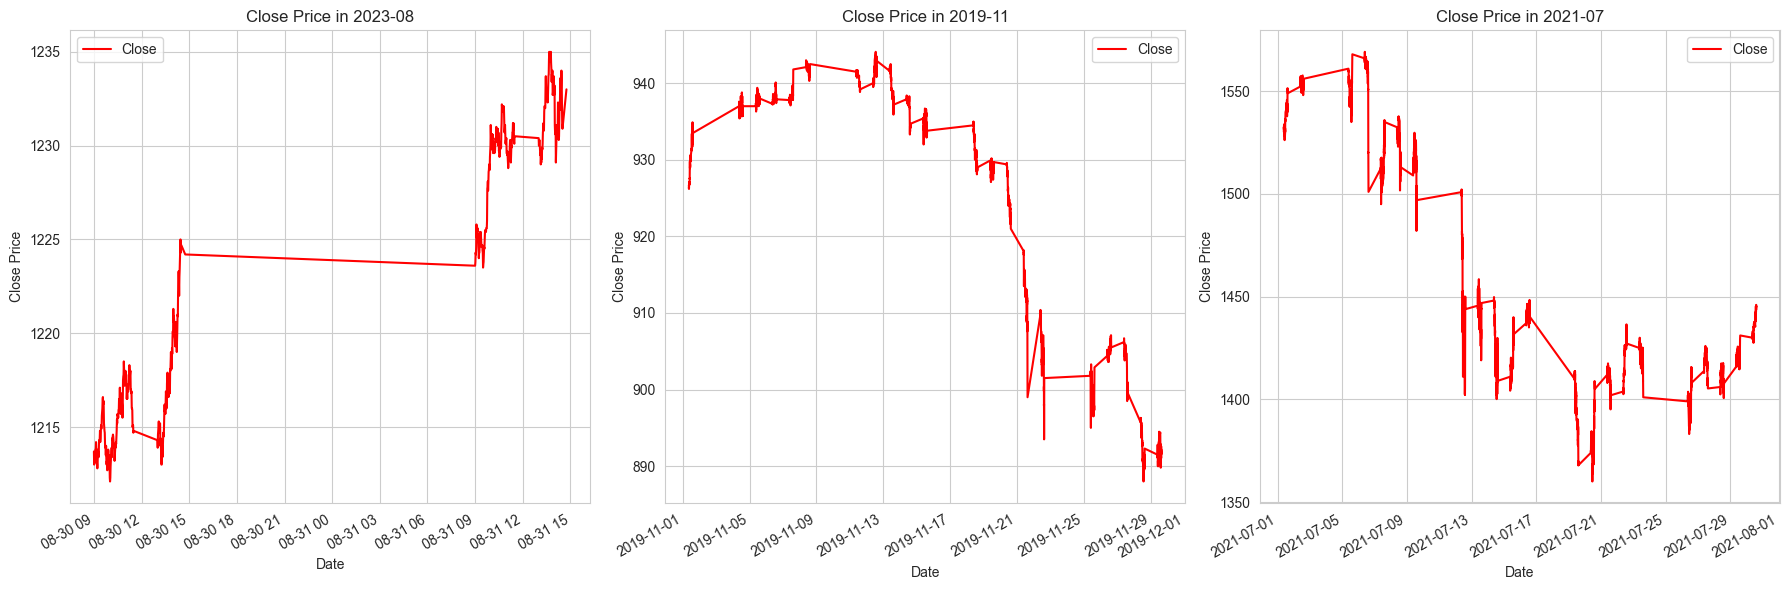

In [40]:
# Lấy ngẫu nhiên 3 khoảng thời gian, mỗi khoảng kéo dài một tháng
def get_random_months(data, num_months=3):
    import random
    # Lấy danh sách các tháng có trong dữ liệu
    months = data.index.to_period('M').unique()
    # Chọn ngẫu nhiên các tháng
    selected_months = random.sample(list(months), num_months)
    return selected_months

# Hàm để lấy dữ liệu trong khoảng thời gian một tháng
def get_data_for_month(data, month):
    return data[data.index.to_period('M') == month]

# Lấy 3 tháng ngẫu nhiên
selected_months = get_random_months(sub_df)

# Tạo các subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Vẽ dữ liệu cho mỗi tháng ngẫu nhiên
for i, month in enumerate(selected_months):
    month_data = get_data_for_month(sub_df, month)
    month_data['Close'].plot(ax=axs[i], legend=True, c='r')
    axs[i].set_title(f'Close Price in {month}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Close Price')

plt.tight_layout()
plt.show()

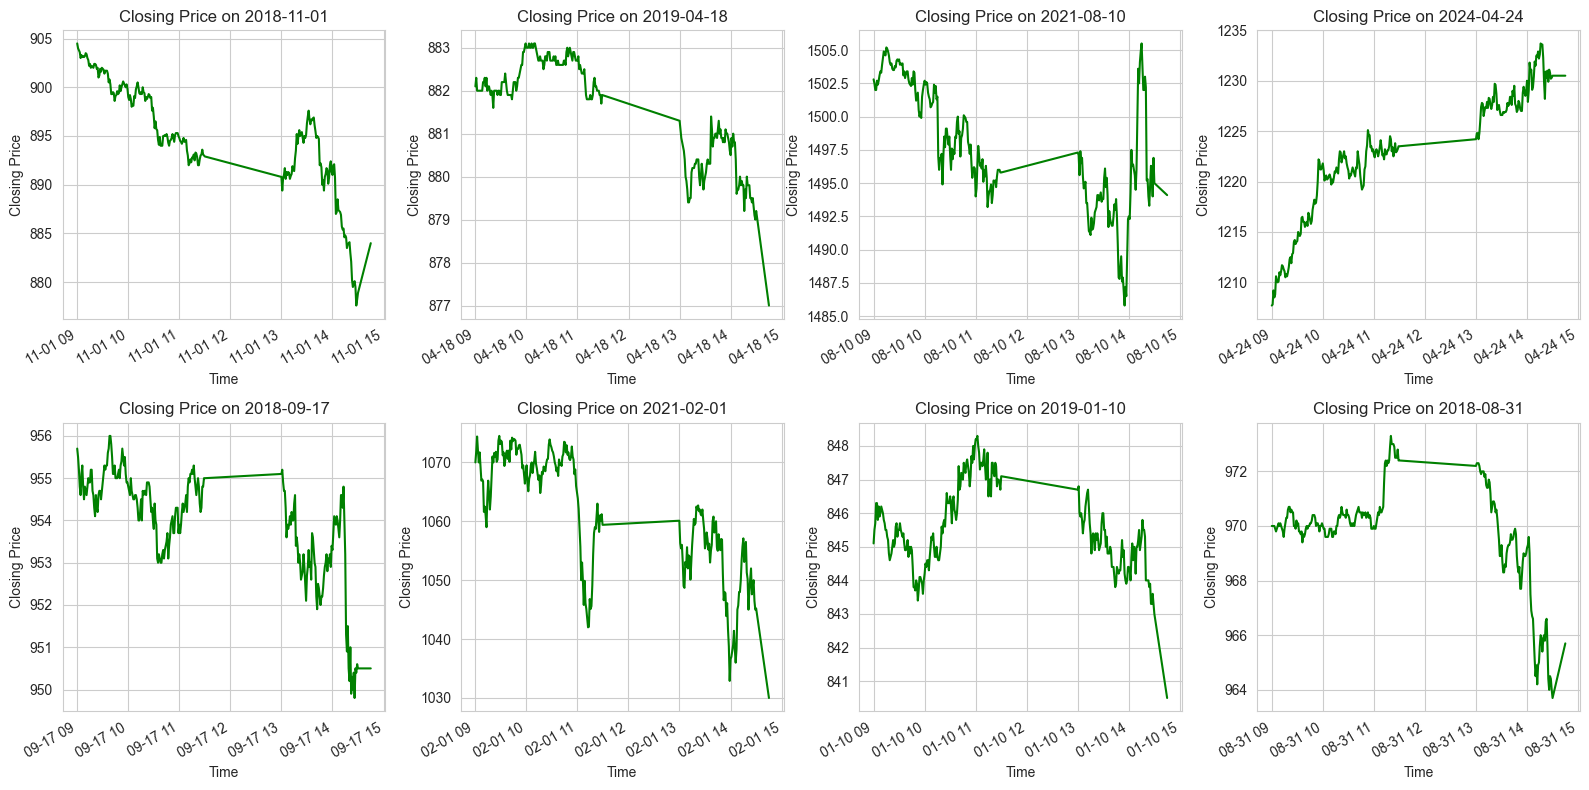

In [41]:
import random
import matplotlib.pyplot as plt

# Hàm để lấy ngẫu nhiên 8 ngày
def get_random_days(data, num_days=8):
    # Lấy danh sách các ngày có trong dữ liệu
    days = data.index.normalize().unique()
    # Chọn ngẫu nhiên các ngày
    selected_days = random.sample(list(days), num_days)
    return selected_days

# Hàm để lấy dữ liệu trong khoảng thời gian một ngày
def get_data_for_day(data, day):
    return data[data.index.normalize() == day]

# Lấy 8 ngày ngẫu nhiên
selected_days = get_random_days(sub_df, num_days=8)

# Tạo các subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Vẽ dữ liệu cho mỗi ngày ngẫu nhiên
for i, day in enumerate(selected_days):
    row = i // 4
    col = i % 4
    day_data = get_data_for_day(sub_df, day)
    day_data['Close'].plot(ax=axs[row, col], legend=False, c='g')
    axs[row, col].set_title(f'Closing Price on {day.date()}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Closing Price')

plt.tight_layout()
plt.show()


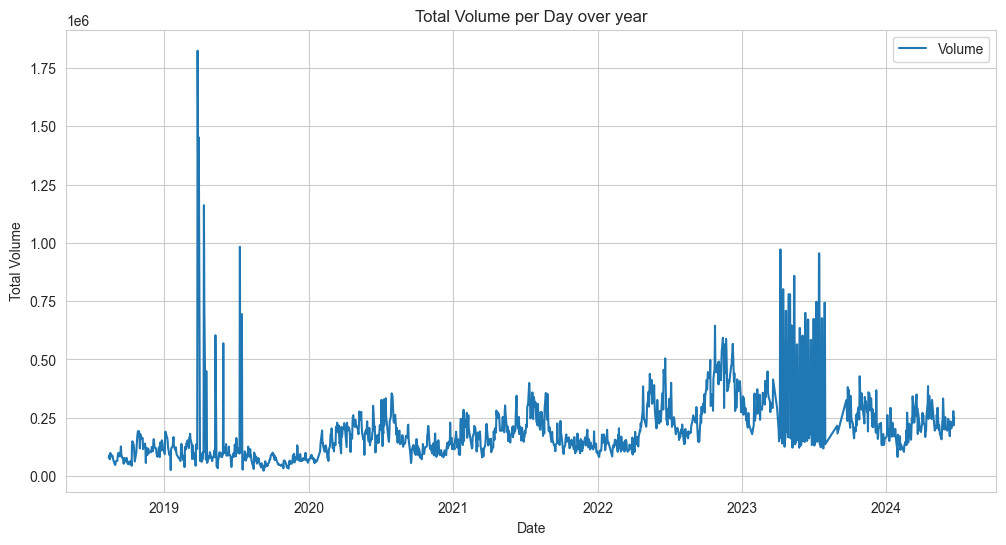

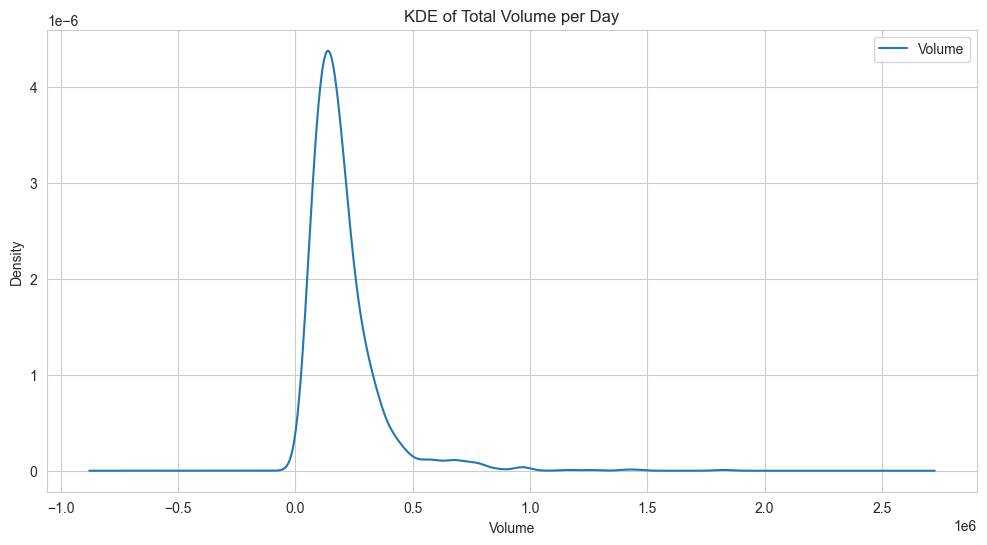

In [42]:
import pandas as pd

# Chuyển cột index sang Datetime
sub_df.index = pd.to_datetime(sub_df.index)

# Tính tổng volume hàng ngày
daily_sum = sub_df['Volume'].groupby(sub_df.index.to_series().dt.date).sum()

# Plot tổng volume hàng ngày
daily_sum.plot(legend=True, figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.title('Total Volume per Day over year')
plt.show()

# Plot KDE cho dữ liệu volume hàng ngày
daily_sum.plot(kind='kde', legend=True, figsize=(12, 6))
plt.xlabel('Volume')
plt.title('KDE of Total Volume per Day')
plt.show()


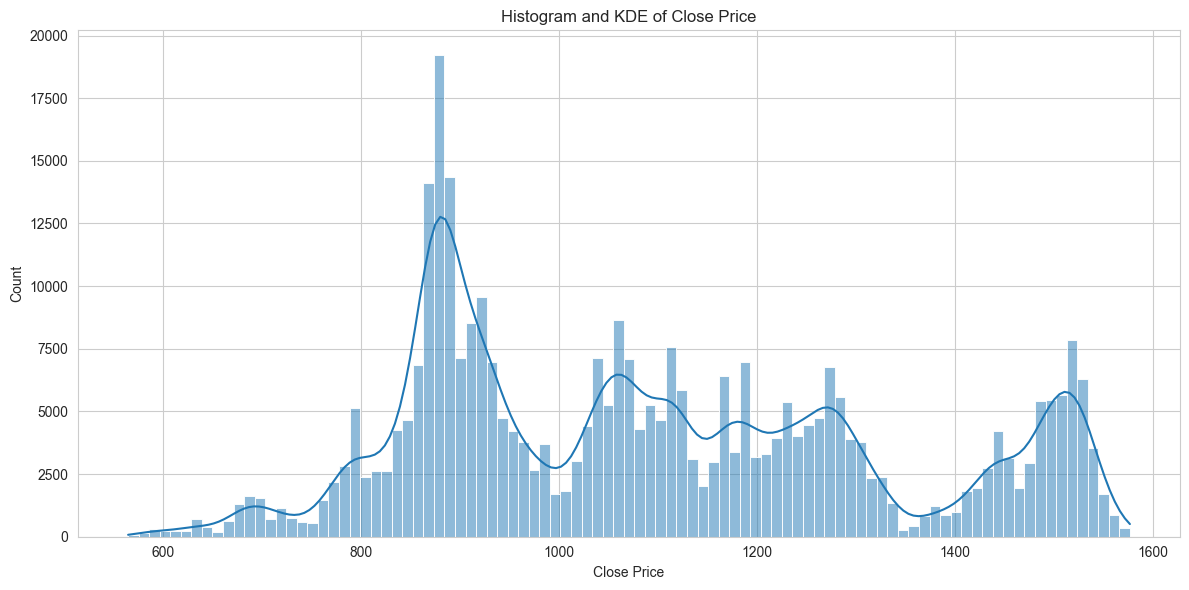

In [43]:
# Histogram and KDE
plt.figure(figsize=(12, 6))
sns.histplot(df['Close'], kde=True)
plt.xlabel('Close Price')
plt.title('Histogram and KDE of Close Price')
plt.tight_layout()
plt.show()

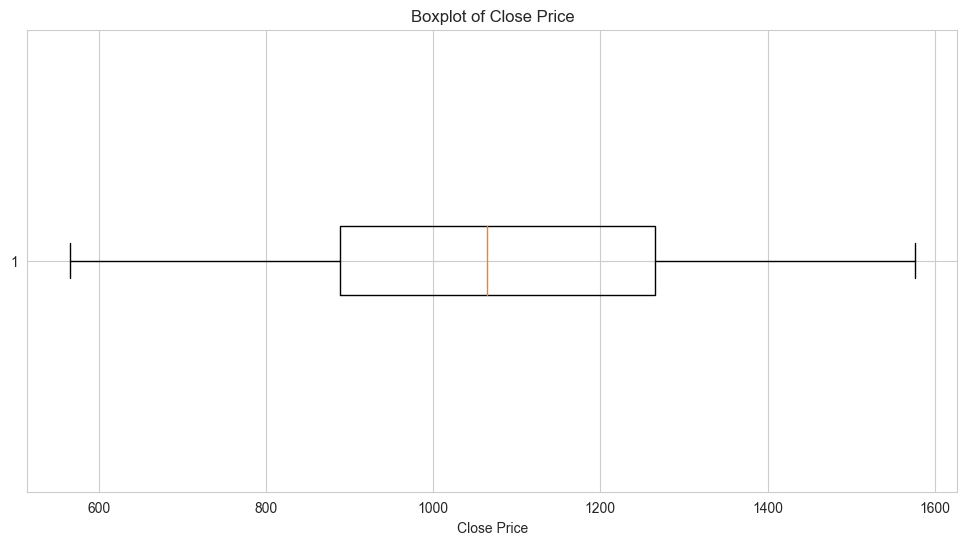

In [44]:
import matplotlib.pyplot as plt

# Giả sử df là DataFrame và có cột 'Close'

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ boxplot nằm ngang
plt.boxplot(sub_df['Close'], vert=False)

# Thiết lập tiêu đề cho trục x và tiêu đề của biểu đồ
plt.xlabel('Close Price')
plt.title('Boxplot of Close Price')

# Hiển thị biểu đồ
plt.show()


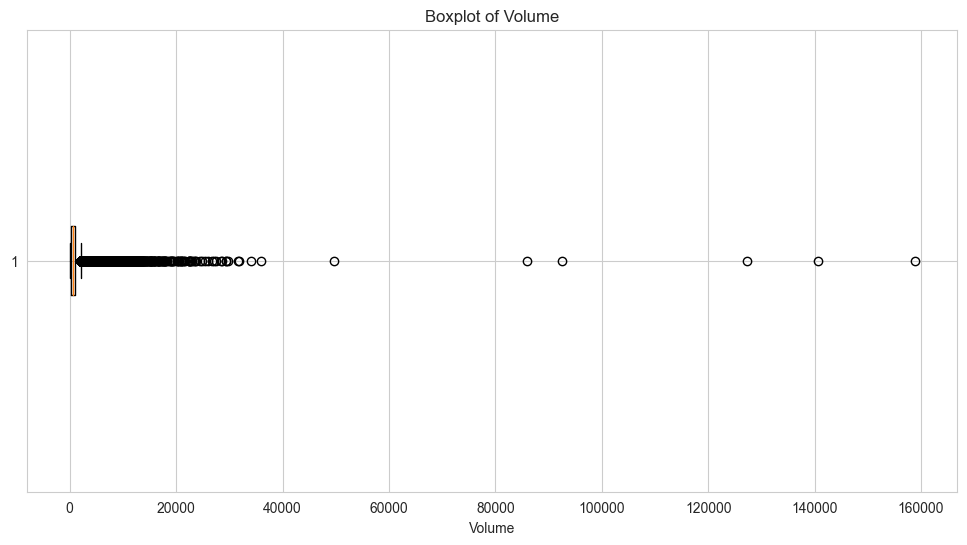

In [45]:
import matplotlib.pyplot as plt

# Giả sử df là DataFrame và có cột 'Close'

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ boxplot nằm ngang
plt.boxplot(sub_df['Volume'], vert=False)

# Thiết lập tiêu đề cho trục x và tiêu đề của biểu đồ
plt.xlabel('Volume')
plt.title('Boxplot of Volume')

# Hiển thị biểu đồlumeVolume
plt.show()


In [46]:
sub_df[sub_df['Volume']>60000]

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-03 14:23:00,773.8,773.9,773.7,773.7,158907.0
2020-07-09 13:27:00,809.7,809.8,809.1,809.3,127257.0
2020-07-13 13:00:00,806.3,806.4,805.5,806.0,92561.0
2020-07-14 13:44:00,798.5,798.5,798.3,798.5,140732.0
2020-07-15 11:11:00,815.0,815.2,815.0,815.2,86007.0


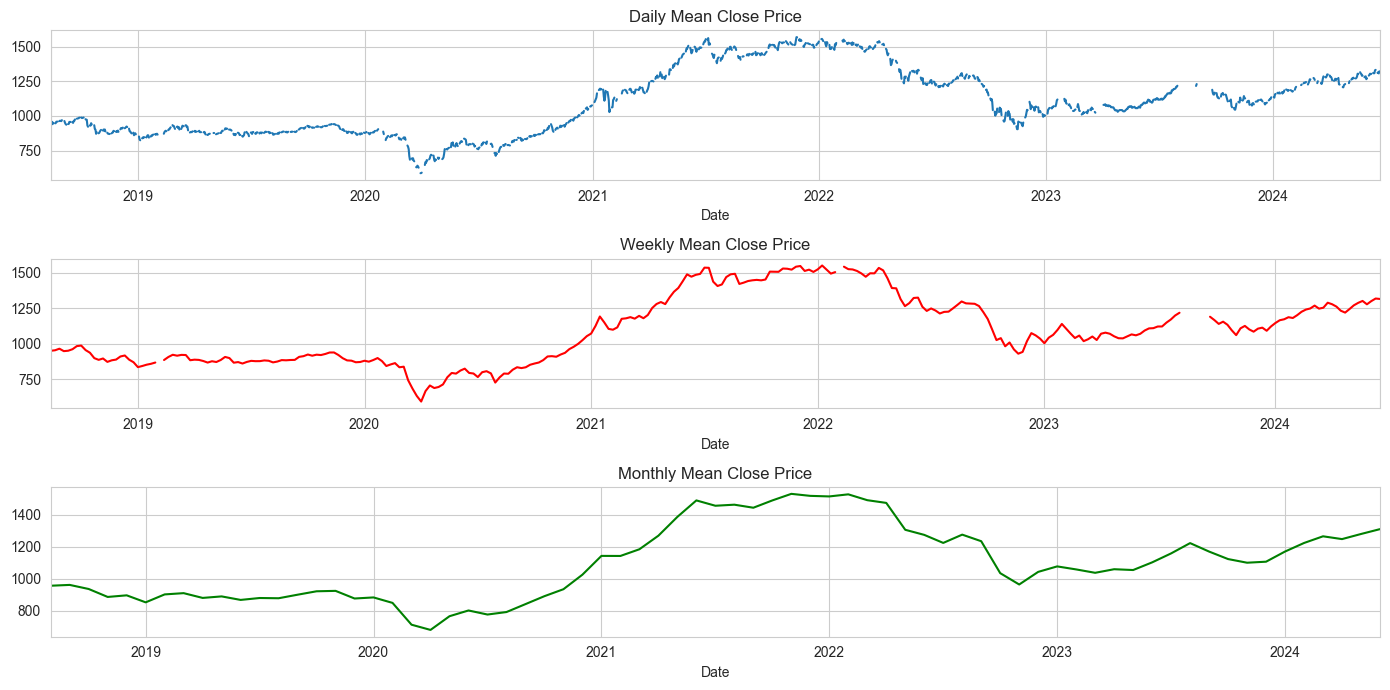

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Chuyển đổi dữ liệu thành chuỗi thời gian nếu chưa
sub_df.index = pd.to_datetime(sub_df.index)

# Tính giá đóng cửa trung bình hàng ngày, hàng tuần và hàng tháng
daily_mean = sub_df['Close'].resample('D').mean()
weekly_mean = sub_df['Close'].resample('W').mean()
monthly_mean = sub_df['Close'].resample('M').mean()

# Vẽ biểu đồ giá đóng cửa trung bình
plt.figure(figsize=(14, 7))
plt.subplot(3, 1, 1)
daily_mean.plot(title='Daily Mean Close Price')
plt.subplot(3, 1, 2)
weekly_mean.plot(title='Weekly Mean Close Price', c='r')
plt.subplot(3, 1, 3)
monthly_mean.plot(title='Monthly Mean Close Price', c='g')
plt.tight_layout()
plt.show()


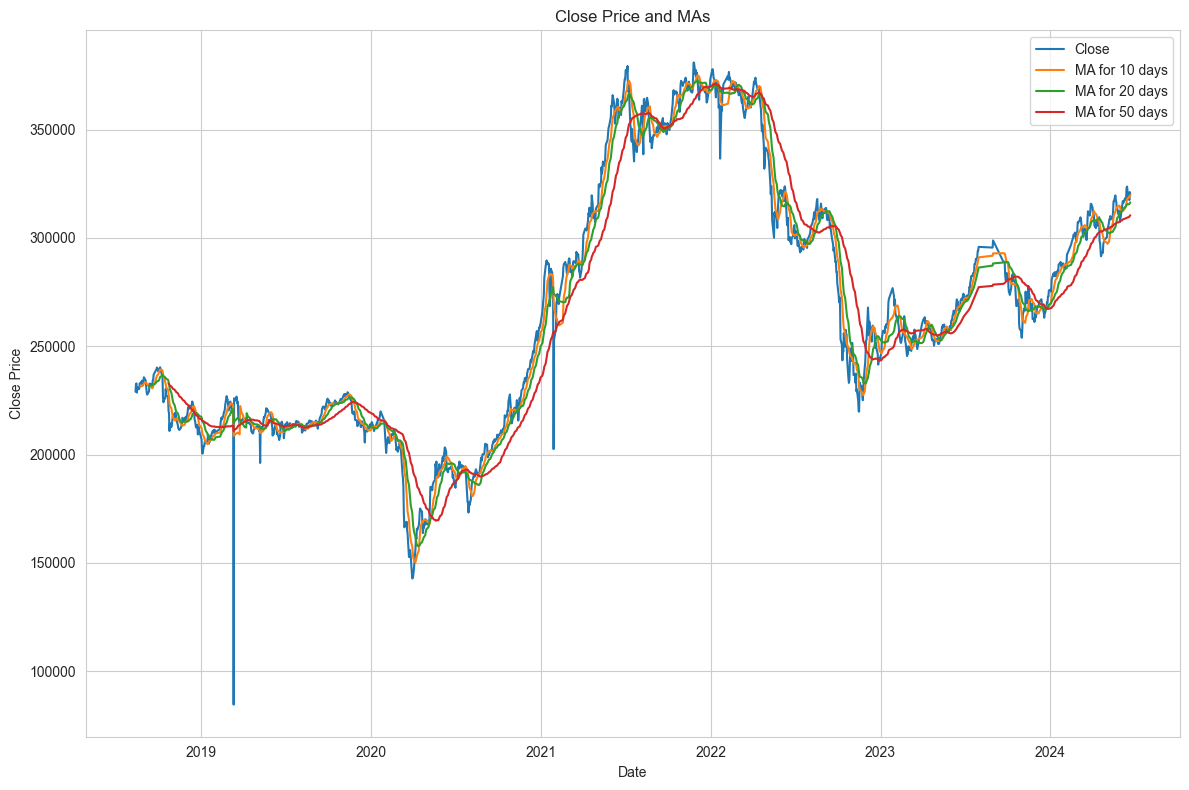

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử sub_df đã tồn tại và có chỉ số datetime

# Nhóm dữ liệu theo ngày và tính tổng cột Close
daily_sum = sub_df['Close'].groupby(sub_df.index.date).sum()

# Chuyển lại thành DataFrame
daily_sum_df = daily_sum.to_frame(name='Close')

# Tính các đường trung bình động
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    daily_sum_df[column_name] = daily_sum_df['Close'].rolling(window=ma).mean()

# Chọn cột cần thiết để vẽ
plot_columns = ['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']
data_to_plot = daily_sum_df[plot_columns]

# Tạo một plot duy nhất cho toàn bộ dữ liệu
fig, ax = plt.subplots(figsize=(12, 8))

data_to_plot.plot(ax=ax, legend=True)
start_date = data_to_plot.index[0].strftime('%Y-%m-%d')
end_date = data_to_plot.index[-1].strftime('%Y-%m-%d')
ax.set_title(f'Close Price and MAs')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

# Điều chỉnh layout để đồ thị không bị chèn lấn
plt.tight_layout()
plt.show()


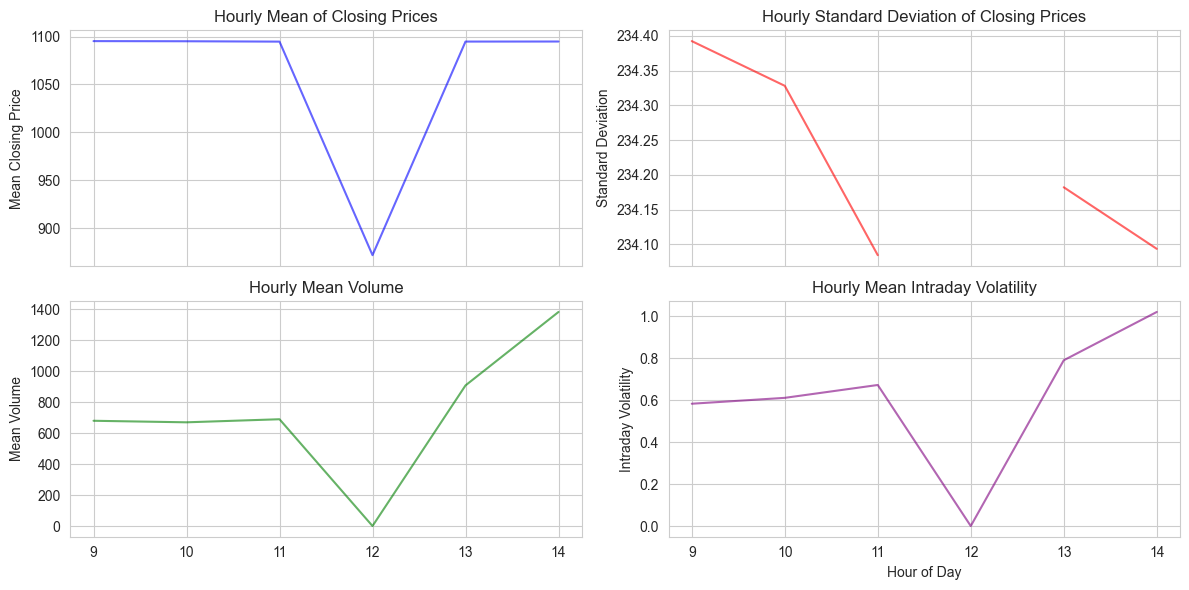

In [49]:
# Thêm cột giờ vào DataFrame
sub_df['Hour'] = sub_df.index.hour

# Tính toán các chỉ số theo giờ
hourly_mean = sub_df.groupby('Hour')['Close'].mean()
hourly_std = sub_df.groupby('Hour')['Close'].std()
hourly_volume = sub_df.groupby('Hour')['Volume'].mean()
sub_df['Intraday Volatility'] = sub_df['High'] - sub_df['Low']
hourly_volatility_mean = sub_df.groupby('Hour')['Intraday Volatility'].mean()

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Vẽ biểu đồ trung bình giá đóng cửa theo giờ
axs[0, 0].plot(hourly_mean.index, hourly_mean, color='blue', alpha=0.6)
axs[0, 0].set_title('Hourly Mean of Closing Prices')
axs[0, 0].set_ylabel('Mean Closing Price')

# Vẽ biểu đồ độ lệch chuẩn giá đóng cửa theo giờ
axs[0, 1].plot(hourly_std.index, hourly_std, color='red', alpha=0.6)
axs[0, 1].set_title('Hourly Standard Deviation of Closing Prices')
axs[0, 1].set_ylabel('Standard Deviation')

# Vẽ biểu đồ khối lượng giao dịch trung bình theo giờ
axs[1, 0].plot(hourly_volume.index, hourly_volume, color='green', alpha=0.6)
axs[1, 0].set_title('Hourly Mean Volume')
axs[1, 0].set_ylabel('Mean Volume')

# Vẽ biểu đồ biến động giá trung bình trong ngày theo giờ
axs[1, 1].plot(hourly_volatility_mean.index, hourly_volatility_mean, color='purple', alpha=0.6)
axs[1, 1].set_title('Hourly Mean Intraday Volatility')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Intraday Volatility')

# Tùy chỉnh bố cục và hiển thị biểu đồ
plt.tight_layout()
plt.show()

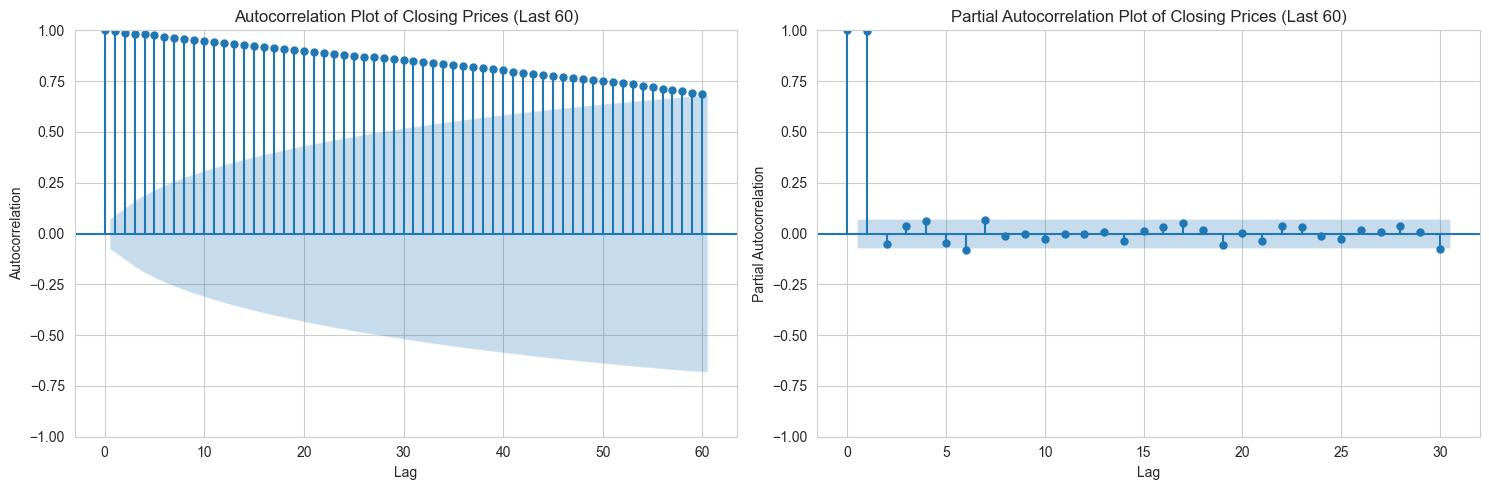

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Giả sử sub_df là DataFrame gốc của bạn với dữ liệu theo phút

# Lấy 60 giá trị cuối cùng
last_60 = sub_df['Close'].iloc[-241*3:]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Autocorrelation plot
plot_acf(last_60, lags=60, ax=axs[0])  # Giới hạn số lags để dễ đọc hơn, bạn có thể thay đổi giá trị lags nếu cần thiết
axs[0].set_title('Autocorrelation Plot of Closing Prices (Last 60)')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].grid(True)

# Partial Autocorrelation plot
plot_pacf(last_60, lags=30, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Plot of Closing Prices (Last 60)')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].grid(True)

# Điều chỉnh layout để đồ thị không bị chèn lấn
plt.tight_layout()
plt.show()


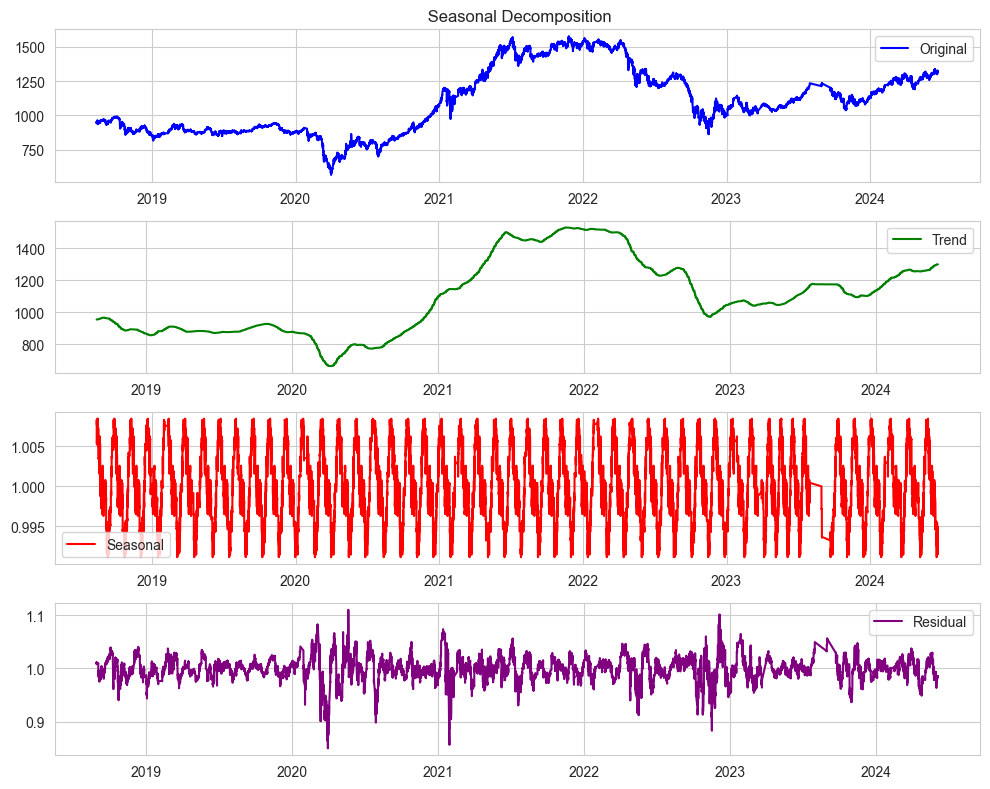

In [52]:
# 6.2 : Seasonal decomposition using seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(sub_df['Close'], model='multiplicative', period=30*241)  # Adjust period if necessary

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(sub_df.index, sub_df['Close'], label='Original', color='blue')
plt.legend()
plt.title(' Seasonal Decomposition')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()